# Setup

In [2]:
import numpy as np
import torch
import torch.autograd as autograd

# For the Gaussian process regression
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy

# For the optimization
import cyipopt
from cyipopt import Problem

# For the NTR
from scipy.spatial import ConvexHull

# For finding minimal disance to the NTR
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

# For hermite quadrature
import itertools
from itertools import product, combinations
from numpy.polynomial.hermite import hermgauss
from scipy.special import roots_hermite as hermgauss

# for QMC (quasi-Monte Carlo)
from torch.quasirandom import SobolEngine
import chaospy

# Plotting
import matplotlib as mpl
from cycler import cycler
from matplotlib import pyplot as plt
import matplotx
from mpl_toolkits.mplot3d import Axes3D
import scienceplots

import logging
from joblib import Parallel, delayed
import os

import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

# Set up logging configuration
logging.basicConfig(filename='optimization_log.txt', 
                    filemode='w',
                    level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

import random
random_seed = 20011210
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)


In [3]:
num_samples = 1000  # Adjust based on desired accuracy

mu = np.array([0.15, 0.15])
Sigma = np.array([[0.17, 0.0], [0.0, 0.17]])

# Sample returns from the log-normal distribution
Rt_samples = torch.exp(torch.distributions.MultivariateNormal(
    torch.tensor(mu, dtype=torch.float32),
    torch.tensor(Sigma, dtype=torch.float32)
).sample((num_samples,)))

Rt_samples


tensor([[2.4083, 1.0790],
        [1.4362, 0.7772],
        [0.9883, 2.7720],
        ...,
        [0.4980, 1.8244],
        [1.9796, 0.9329],
        [3.3306, 1.0125]])

## Designing a custom plotting style and updating scienceplots

In [4]:
plt.style.use('science')

custom = True
if custom:

    colors = ['#cc2300','#094a84', 
                '#009437', '#cc7700',
                '#694878', '#383838',
                '#7e7e7e']
    mpl.rcParams['axes.prop_cycle'] = cycler('color', 
                                            ['#cc2300','#094a84', 
                                            '#009437', '#cc7700',
                                            '#694878', '#383838',
                                            '#7e7e7e'])

    mpl.rcParams['figure.facecolor'] = '#ffffff'  # Lightest Snow Storm background
    mpl.rcParams['axes.facecolor'] = '#FCFDFE'    # Same light background inside plots
    mpl.rcParams['axes.facecolor'] = '#ffffff'    # Same light background inside plots
    # mpl.rcParams['axes.facecolor'] = '#3B4252'    # Same light background inside plots
    # # mpl.rcParams['axes.facecolor'] = '#ffffff'    # Same light background inside plots
    # mpl.rcParams['axes.edgecolor'] = '#3B4252'    # Dark Slate from Polar Night for edges
    # mpl.rcParams['axes.labelcolor'] = '#3B4252'   # Text color for labels using Dark Slate
    # mpl.rcParams['xtick.color'] = '#3B4252'       # Tick color from Polar Night palette
    # mpl.rcParams['ytick.color'] = '#3B4252'

    mpl.rcParams['font.size'] = 12
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['axes.labelsize'] = 14
    mpl.rcParams['legend.fontsize'] = 12

    # Remove spines
    # mpl.rcParams['axes.spines.top'] = False
    # mpl.rcParams['axes.spines.right'] = False
    # mpl.rcParams['axes.spines.bottom'] = False
    # mpl.rcParams['axes.spines.left'] = False

    # Grid settings
    mpl.rcParams['axes.grid'] = True
    # mpl.rcParams['grid.color'] = '#ffffff'        # Subtle grid lines using light Snow Storm color
    mpl.rcParams['grid.linestyle'] = '--'
    mpl.rcParams['grid.linewidth'] = 0.8
    mpl.rcParams['axes.titlecolor'] = 'black'
    # Ticks
    mpl.rcParams['xtick.major.size'] = 5
    mpl.rcParams['ytick.major.size'] = 5
    mpl.rcParams['xtick.minor.size'] = 3
    mpl.rcParams['ytick.minor.size'] = 3
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['ytick.direction'] = 'in'

    # Lines and markers
    mpl.rcParams['lines.linewidth'] = 3
    mpl.rcParams['lines.markersize'] = 6
    mpl.rcParams['lines.markeredgewidth'] = 1.5

    # Legends
    mpl.rcParams['legend.frameon'] = True
    mpl.rcParams['legend.loc'] = 'best'

    # Subplots and layout
    mpl.rcParams['figure.figsize'] = [8, 6]
    mpl.rcParams['figure.dpi'] = 600
    mpl.rcParams['figure.autolayout'] = True

    # Always save as 'tight'
    mpl.rcParams['savefig.bbox'] = 'tight'
    mpl.rcParams['savefig.pad_inches'] = 0.02

    # Save figures to the folder Figures
    output_folder = '../Speciale dokumentet/Figures'
    os.makedirs(output_folder, exist_ok=True)

## How do we sample points for the problem? 2D

In [5]:
import numpy as np
from scipy.spatial import ConvexHull

def point_in_convex_hull(hull, point):
    """
    Check if a point is inside the convex hull.
    
    Args:
        hull (scipy.spatial.ConvexHull): Convex hull object defining the NTR.
        point (ndarray): Point to check, shape [D].
    
    Returns:
        bool: True if the point is inside the convex hull, False otherwise.
    """
    return np.all(np.dot(hull.equations[:, :-1], point) + hull.equations[:, -1] <= 0)

def create_grid(ntr_vertices, grid_density=100):
    """
    Creates a grid of points in the simplex (sum(x_i) <= 1), excluding those inside a convex hull defined by NTR vertices.
    
    Args:
        ntr_vertices (ndarray): Vertices defining the convex hull (NTR), shape [n_vertices, D].
        grid_density (int): Number of points along each dimension.
    
    Returns:
        ndarray: Grid of points excluding the points inside the convex hull.
    """
    # Get the dimension of the problem from the NTR vertices
    D = ntr_vertices.shape[1]
    
    # Create a grid in D dimensions, each dimension ranging from 0 to 1
    grid_ranges = [np.linspace(0, 1, int(grid_density)) for _ in range(D)]
    
    # Create a meshgrid for all D dimensions and flatten it into a list of points
    grid = np.array(np.meshgrid(*grid_ranges)).T.reshape(-1, D)

    # Filter out points where the sum exceeds 1 (outside the simplex)
    simplex_mask = np.sum(grid, axis=1) <= 1

    # Keep only points inside the simplex
    points = grid[simplex_mask]

    return points

def create_grid_excluding_ntr(ntr_vertices, grid_density=100):
    """
    Creates a grid of points in the simplex (sum(x_i) <= 1), excluding those inside a convex hull defined by NTR vertices.
    
    Args:
        ntr_vertices (ndarray): Vertices defining the convex hull (NTR), shape [n_vertices, D].
        grid_density (int): Number of points along each dimension.
    
    Returns:
        ndarray: Grid of points excluding the points inside the convex hull.
    """
    # Create the convex hull from the NTR vertices
    hull = ConvexHull(ntr_vertices)

    # Create a grid of points in the simplex
    grid_points = create_grid(ntr_vertices, grid_density)

    # Filter out points inside the NTR (convex hull)
    mask = np.array([not point_in_convex_hull(hull, point) for point in grid_points])
    outside_points = grid_points[mask]

    return outside_points

# Reusing the sampling function without changing the logic
def sample_points_around_ntr_separated(ntr_vertices, num_samples, kink_ratio=0.2, inside_ratio=0.25, grid_density=25):
    """
    Samples points around kinks, inside the NTR, and in the general state space excluding NTR.
    """
    hull = ConvexHull(ntr_vertices)

    # Sample points inside the NTR
    num_inside = int(num_samples * inside_ratio)
    inside_points = np.array([
        np.dot(np.random.dirichlet(np.ones(len(hull.vertices)), size=1), ntr_vertices[hull.vertices]).squeeze(0)
        for _ in range(num_inside)
    ])

    # Sample points around the kinks using linear interpolation with noise
    num_kinks = int(num_samples * kink_ratio)
    kink_points = []
    for i in range(len(ntr_vertices)):
        for _ in range(num_kinks // len(ntr_vertices)):
            alpha = np.random.uniform(0.8, 1.2)  # Interpolation factor
            beta = 1 - alpha
            point = alpha * ntr_vertices[i] + beta * ntr_vertices[(i + 1) % len(ntr_vertices)]
            kink_points.append(point + np.random.uniform(-0.01, 0.01, size=len(ntr_vertices[0])))  # Small noise
    kink_points = np.array(kink_points)

    # Create a grid and exclude points inside the NTR
    general_points = create_grid_excluding_ntr(ntr_vertices, grid_density)
    num_general = num_samples #- len(inside_points) - len(kink_points)
    num_general = num_samples - len(inside_points) - len(kink_points)
    if num_general > 0:
        general_points = general_points[np.random.choice(len(general_points), size=num_general, replace=False)]

    return inside_points, kink_points, general_points


In [6]:
# Define the NTR 
ntr_vertices = np.array([
    [0.15, 0.4],
    [0.4, 0.4],
    [0.4, 0.15],
    [0.15, 0.15]
])


# Save Uniform grid plot
plt.figure(figsize=(8, 6))
# plt.title('Uniform Grid')
hull = ConvexHull(ntr_vertices)
for simplex in hull.simplices:
    plt.plot(ntr_vertices[simplex, 0], ntr_vertices[simplex, 1], 'k-')
ntr_vertices_closed = np.append(ntr_vertices, [ntr_vertices[0]], axis=0)
plt.plot(ntr_vertices_closed[:, 0], ntr_vertices_closed[:, 1], label='NTR')
plt.xlabel('Allocation, risky asset 1')
plt.ylabel('Allocation, risky asset 2')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '' if x == 0 else f'{x:.1f}'))
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_folder, 'Example_NTR.png'))
plt.close()

In [7]:
# Define the NTR 
ntr_vertices = np.array([
    [0.1, 0.2],
    [0.2, 0.2],
    [0.2, 0.1],
    [0.1, 0.1]
])

# Sample points
num_samples = 100
np.random.seed(20011210)
points_inside_ntr, points_around_kinks, points_outside_ntr = sample_points_around_ntr_separated(ntr_vertices, num_samples, kink_ratio=0.25, inside_ratio=0.25, grid_density=25)
_, _, naive_points = sample_points_around_ntr_separated(np.array([[-0.5,0.5],[-0.6,-0.6],[-0.7,-0.7]]), num_samples, kink_ratio=0., inside_ratio=0.0, grid_density=25)
uniform_grid = create_grid(ntr_vertices, grid_density=25)
print(f"Number of points inside NTR: {len(points_inside_ntr)}, around kinks: {len(points_around_kinks)}, outside NTR: {len(points_outside_ntr)}")

# Save Uniform grid plot
plt.figure(figsize=(8, 6))
# plt.title('Uniform Grid')
hull = ConvexHull(ntr_vertices)
for simplex in hull.simplices:
    plt.plot(ntr_vertices[simplex, 0], ntr_vertices[simplex, 1], 'k-')
ntr_vertices_closed = np.append(ntr_vertices, [ntr_vertices[0]], axis=0)
plt.plot(ntr_vertices_closed[:, 0], ntr_vertices_closed[:, 1], label='NTR', color=colors[0])
plt.scatter(uniform_grid[:, 0], uniform_grid[:, 1], label='Uniform Grid', alpha=0.75, color=colors[1])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '' if x == 0 else f'{x:.1f}'))
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_folder, 'uniform_grid.png'))
plt.close()

# Save Naive sampling strategy plot
plt.figure(figsize=(8, 6))
# plt.title('Naive Sampling Strategy')
hull = ConvexHull(ntr_vertices)
# for simplex in hull.simplices:
#     plt.plot(ntr_vertices[simplex, 0], ntr_vertices[simplex, 1], 'k-')
ntr_vertices_closed = np.append(ntr_vertices, [ntr_vertices[0]], axis=0)
plt.plot(ntr_vertices_closed[:, 0], ntr_vertices_closed[:, 1], label='NTR', color=colors[0])
plt.scatter(naive_points[:, 0], naive_points[:, 1], label='General State Space', alpha=0.75, color=colors[1])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '' if x == 0 else f'{x:.1f}'))
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_folder, 'naive_sampling_strategy.png'))
plt.close()

# Save Non-Naive sampling strategy plot
plt.figure(figsize=(8, 6))
# plt.title('Designed Sampling Strategy')
hull = ConvexHull(ntr_vertices)

ntr_vertices_closed = np.append(ntr_vertices, [ntr_vertices[0]], axis=0)
plt.plot(ntr_vertices_closed[:, 0], ntr_vertices_closed[:, 1], label='NTR', color=colors[0])
plt.scatter(points_outside_ntr[:, 0], points_outside_ntr[:, 1], label='General State Space', alpha=0.75, color=colors[1])
plt.scatter(points_inside_ntr[:, 0], points_inside_ntr[:, 1], label='Inside NTR', alpha=0.75, color=colors[2])
plt.scatter(points_around_kinks[:, 0], points_around_kinks[:, 1], label='Around Kinks', alpha=0.75, color=colors[3])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '' if x == 0 else f'{x:.1f}'))
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_folder, 'designed_sampling_strategy.png'))
plt.close()

# Save Zoomed Non-Naive sampling strategy plot
plt.figure(figsize=(8, 6))
# plt.title('Designed Sampling Strategy')
hull = ConvexHull(ntr_vertices)
# for simplex in hull.simplices:
#     plt.plot(ntr_vertices[simplex, 0], ntr_vertices[simplex, 1], 'k-')
ntr_vertices_closed = np.append(ntr_vertices, [ntr_vertices[0]], axis=0)
plt.plot(ntr_vertices_closed[:, 0], ntr_vertices_closed[:, 1], label='NTR', color=colors[0], linewidth=4)
plt.scatter(points_outside_ntr[:, 0], points_outside_ntr[:, 1], label='General State Space', alpha=0.75, color=colors[1], s=100)
plt.scatter(points_inside_ntr[:, 0], points_inside_ntr[:, 1], label='Inside NTR', alpha=0.75, color=colors[2], s=100)
plt.scatter(points_around_kinks[:, 0], points_around_kinks[:, 1], label='Around Kinks', alpha=0.75, color=colors[3], s=100)
plt.xlim(0.05, 0.3)
plt.ylim(0.05, 0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '' if x == 0 else f'{x:.1f}'))
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_folder, 'zoomed_designed_sampling_strategy.png'))
plt.close()

Number of points inside NTR: 25, around kinks: 24, outside NTR: 51


In [8]:

# # Define the GPR model with ARD
# class GPRegressionModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(
#             gpytorch.kernels.MaternKernel(nu=0.5, ard_num_dims=train_x.shape[1]),
#             # gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1]),
#             # gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=train_x.shape[1]),
#             jitter=1e-8  # Adding jitter for numerical stability
#         )

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# def train_gp_model(train_x, train_y, patience=200, min_delta=1e-6, max_iterations=200):
#     """
#     Trains a Gaussian Process Regression model with early stopping.

#     Args:
#         train_x (torch.Tensor): Training inputs. Shape: [num_samples, D]
#         train_y (torch.Tensor): Training targets. Shape: [num_samples]
#         patience (int): Number of iterations to wait for improvement before stopping.
#         min_delta (float): Minimum change in the loss to qualify as an improvement.
#         max_iterations (int): Maximum number of iterations to run.

#     Returns:
#         model (GPRegressionModel): Trained GP model.
#         likelihood (gpytorch.likelihoods.GaussianLikelihood): Associated likelihood.
#     """
#     likelihood = gpytorch.likelihoods.GaussianLikelihood(
#         noise_constraint=gpytorch.constraints.GreaterThan(1e-8)
#     )
#     model = GPRegressionModel(train_x, train_y, likelihood)
#     model.train()
#     likelihood.train()

#     optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
#     mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

#     best_loss = float('inf')
#     no_improvement_count = 0

#     for i in range(max_iterations):
#         optimizer.zero_grad()
#         output = model(train_x)
#         loss = -mll(output, train_y)
#         loss.backward()
#         optimizer.step()

#         current_loss = loss.item()

#         # Check for improvement
#         if current_loss < best_loss - min_delta:
#             best_loss = current_loss
#             no_improvement_count = 0  # Reset the counter if we see improvement
#         else:
#             no_improvement_count += 1  # Increment if no improvement

#         # Early stopping condition
#         if no_improvement_count >= patience:
#             print(f"Early stopping at iteration {i+1}")
#             break

#     return model, likelihood

In [9]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')

torch.random.get_rng_state()
np.random.seed(seed=None)

# Set print options
torch.set_printoptions(sci_mode=False, precision=4)
np.set_printoptions(suppress=True, precision=4)

# Limit PyTorch and NumPy to use a single thread per worker
torch.set_num_threads(1)
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

def get_hermite_nodes_weights(n_q):
    nodes_1d, weights_1d = hermgauss(n_q)
    # Adjust nodes and weights for the standard normal distribution
    nodes_1d = nodes_1d * np.sqrt(2)
    weights_1d = weights_1d / np.sqrt(np.pi)
    return nodes_1d, weights_1d

def get_multidimensional_nodes_weights(nodes_1d, weights_1d, D):
    nodes = list(itertools.product(nodes_1d, repeat=D))
    weights = list(itertools.product(weights_1d, repeat=D))
    nodes = np.array(nodes)
    weights = np.array(weights)
    weights = np.prod(weights, axis=1)
    return nodes, weights

def transform_nodes(nodes, mu, Sigma, jitter=1e-8):
    
    
    try:
        # L = np.linalg.cholesky(Sigma)
        L = np.linalg.cholesky(Sigma + jitter * np.eye(Sigma.shape[0]))
    except np.linalg.LinAlgError:
        raise ValueError("Covariance matrix is not positive definite even after adding jitter.")
    
   
    # adjusted_mu = mu * Delta_t # Standard
    # adjusted_mu = (mu)*Delta_t
    adjusted_mu = (mu-0.5*np.diag(Sigma))*Delta_t

    transformed_nodes = ( nodes @ L.T ) * np.sqrt(Delta_t) + adjusted_mu 
    # i want to add diagonal of sigma to the mu

    return transformed_nodes, L

class VariationalGPRegressionModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(VariationalGPRegressionModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=0.5, ard_num_dims=inducing_points.size(1)),
            jitter=1e-8  # Adding jitter for numerical stability
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp_model(train_x, train_y, batch_size=64, num_epochs=20):
    # inducing_points = train_x[:500]  # Use a subset as inducing points
    inducing_points = train_x
    model = VariationalGPRegressionModel(inducing_points)
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-8))
    model.train()
    likelihood.train()

    # Use the Adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], 
    # lr=0.01)
    lr=0.2)

    # Use the Variational ELBO
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

    # Create a DataLoader for batch training
    train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()
    
    return model, likelihood


def utility(var, gamma):
    """
    Computes CRRA utility.

    Args:
        var (torch.Tensor): Variable to compute utility for.
        gamma (float): Coefficient of relative risk aversion.

    Returns:
        torch.Tensor: Utility values.
    """
    # var = torch.clamp(var, min=1e-4)
    if gamma == 1:
        return torch.log(var)  # Log utility for gamma = 1
    else:
        return (var ** (1.0 - gamma)) / (1.0 - gamma)  # CRRA utility      #Which is correct?

def normalized_bond_holdings(xt, delta_plus, delta_minus, tau, Delta_t, ct=None, include_consumption=False):
    """
    Computes normalized bond holdings.
    
    Args:
        xt (torch.Tensor): Current holdings. Shape: [1, D]
        delta_plus (torch.Tensor): Adjustments (increases). Shape: [1, D]
        delta_minus (torch.Tensor): Adjustments (decreases). Shape: [1, D]
        tau (float): Transaction cost rate.
        Delta_t (float): Time step size.
        c_min (float): Minimum consumption.
        ct (torch.Tensor or None): Consumption. Shape: [1]
        include_consumption (bool): Flag to include consumption.
    
    Returns:
        torch.Tensor: Bond holdings. Scalar tensor.
    """
    if not include_consumption:
        ct = torch.tensor([0.0], dtype=torch.float32)  # Ensure ct is tensor of shape [1]
    bt = 1.0 - torch.sum(xt + delta_plus - delta_minus) - torch.sum(tau * (delta_plus + delta_minus)) - torch.sum(ct) * Delta_t
    return bt  # Scalar tensor

def normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf, tau):
    """
    Computes next period's state dynamics.

    Args:
        xt (torch.Tensor): Current holdings. Shape: [1, D]
        delta_plus (torch.Tensor): Adjustments (increases). Shape: [1, D]
        delta_minus (torch.Tensor): Adjustments (decreases). Shape: [1, D]
        Rt (torch.Tensor): Returns matrix. Shape: [n_q^D, D]
        bt (torch.Tensor): Bond holdings. Shape: [1]
        Rf (float): Risk-free rate factor.
        tau (float): Transaction cost rate.

    Returns:
        tuple: (pi_t1, xt1, Wt1)
    """
    # Compute next period's portfolio value
    pi_t1 = bt * Rf + torch.sum((xt + delta_plus - delta_minus) * Rt, dim=1, keepdim=True)
    # Compute next period's state
    xt1 = ((xt + delta_plus - delta_minus) * Rt) / pi_t1
    # Wealth is not tracked between periods
    Wt = torch.tensor(1.0, dtype=torch.float32)
    Wt1 = Wt * pi_t1
    return pi_t1, xt1, Wt1

def V_terminal(xT, tau, gamma,r,Delta_t):
    """
    Terminal value function.

    Args:
        xT (torch.Tensor): Holdings at terminal time. Shape: [n_samples, D]
        tau (float): Transaction cost rate.
        gamma (float): Coefficient of relative risk aversion.

    Returns:
        torch.Tensor: Terminal utility values. Shape: [n_samples]
    """
    # terminal_utility = utility((1.0 - tau * torch .sum(xT, dim=-1))*r, gamma)
    terminal_utility = utility((1.0 - tau * torch.sum(xT, dim=-1)*r), gamma)*Delta_t
    
    return terminal_utility  # Shape: [n_samples]

def bellman_equation(
    vt_next_in,
    vt_next_out,
    xt,
    delta_plus,
    delta_minus,
    beta,
    gamma,
    Delta_t,
    tau,
    Rf,
    ct=None,
    include_consumption=False,
    convex_hull=None,
    t=None,
    mu=None,
    Sigma=None,
    quadrature_nodes_weights=None,
    integration_method='quadrature',
    num_mc_samples=1000  # Number of Monte Carlo samples if using MC integration
):
    """
    Computes the value function vt using the Bellman equation with specified integration method.

    Args:
        vt_next_in (gpytorch.models.ExactGP or callable): Value function for inside NTR.
        vt_next_out (gpytorch.models.ExactGP or callable): Value function for outside NTR.
        xt (torch.Tensor): Current state. Shape: [1, D]
        delta_plus (torch.Tensor): Adjustments (increases). Shape: [1, D]
        delta_minus (torch.Tensor): Adjustments (decreases). Shape: [1, D]
        beta (float): Discount factor.
        gamma (float): Coefficient of relative risk aversion.
        Delta_t (float): Time step size.
        tau (float): Transaction cost rate.
        Rf (float): Risk-free rate factor.
        ct (torch.Tensor or None): Consumption at time t.
        include_consumption (bool): Flag to include consumption.
        convex_hull (ConvexHull or None): Convex hull defining the NTR.
        t (int): Current time step.
        mu (np.array): Mean vector for asset returns.
        Sigma (np.array): Covariance matrix for asset returns.
        quadrature_nodes_weights (tuple or None): Quadrature nodes and weights.
        integration_method (str): 'quadrature' or 'monte_carlo'
        num_mc_samples (int): Number of Monte Carlo samples (used if integration_method='monte_carlo')

    Returns:
        torch.Tensor: Value function. Shape: [1]
    """
    D = len(mu)
    assert xt.dim() == 2 and xt.size(0) == 1, f"xt must be [1, D], got {xt.shape}"
    assert delta_plus.dim() == 2 and delta_plus.size(0) == 1, f"delta_plus must be [1, D], got {delta_plus.shape}"
    assert delta_minus.dim() == 2 and delta_minus.size(0) == 1, f"delta_minus must be [1, D], got {delta_minus.shape}"
    if not include_consumption:
        ct = torch.tensor([0.0], dtype=torch.float32)  # Shape: [1]
    # Compute bond holdings
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau, Delta_t, ct, include_consumption)

    if integration_method == 'quadrature':
        # Quadrature integration
        # Check if quadrature nodes and weights are provided; if not, compute them
        if quadrature_nodes_weights is None:
            raise ValueError("No quadrature nodes and weights provided.")
        else:
            transformed_nodes, weights, L = quadrature_nodes_weights

        # Convert to torch tensors
        nodes = torch.tensor(transformed_nodes, dtype=torch.float32)  # Shape: [n_q^D, D]
        weights = torch.tensor(weights, dtype=torch.float32)          # Shape: [n_q^D]

        # Compute Rt
        Rt = torch.exp(nodes)  # Since log_Rt ~ N(mu, Sigma), nodes are log_Rt
        # weights = weights * torch.prod(Rt, dim=1)  # Multiply weights by the product of Rt values for each node

        pi_t1 , xt1 , Wt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf, tau)

    elif integration_method == 'monte_carlo':
        # Monte Carlo integration
        adjusted_mu = (mu - 0.5 * np.diag(Sigma)) * Delta_t #See Cai Judd Xu 2013
        distribution = chaospy.MvNormal(adjusted_mu, Sigma * Delta_t)
        samples = distribution.sample(num_mc_samples, rule='random') 
        log_Rt_samples = torch.tensor(samples.T, dtype=torch.float32)  # Shape: [num_mc_samples, D]
        Rt = torch.exp(log_Rt_samples)

        pi_t1, xt1, Wt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf, tau)

    elif integration_method == 'quasi_monte_carlo':
        # Quasi-Monte Carlo integration using Sobol sequences
        adjusted_mu = mu * Delta_t - 0.5 * np.diag(Sigma) * Delta_t #See Cai Judd Xu 2013
        distribution = chaospy.MvNormal(adjusted_mu, Sigma * Delta_t)
        samples = distribution.sample(num_mc_samples, rule='sobol')  # 'sobol' or 'halton'
        log_Rt_samples = torch.tensor(samples.T, dtype=torch.float32)  # Shape: [num_mc_samples, D]
        Rt = torch.exp(log_Rt_samples)

        pi_t1, xt1, Wt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf, tau)
    else:
        raise ValueError("Invalid integration method. Choose 'quadrature', 'monte_carlo', or 'quasi_monte_carlo'.")    

    # Raise error if NaN or Inf values are encountered
    if torch.isnan(pi_t1).any() or torch.isnan(xt1).any() or torch.isnan(Wt1).any():
        raise ValueError("NaN values encountered in pi_t1, xt1, or Wt1.")

    # raise error of Rt has negative values
    if (Rt<0).any():
        raise ValueError("Negative values encountered in Rt.")

    # Correctly expand delta_plus and delta_minus to match xt1's shape
    delta_plus_expanded = delta_plus.repeat(xt1.size(0), 1)    # Shape: [n_samples, D]
    delta_minus_expanded = delta_minus.repeat(xt1.size(0), 1)  # Shape: [n_samples, D]

    # Determine if next state is inside NTR
    with torch.no_grad():
        in_ntr = is_in_ntr(xt1, convex_hull, delta_plus_expanded, delta_minus_expanded, t=t)  # [n_samples]

    # Evaluate the next period's value function
    vt_next_vals = torch.zeros(xt1.size(0), dtype=torch.float32)

    # Evaluate value functions for inside and outside NTR
    if isinstance(vt_next_in, gpytorch.models.ApproximateGP) or isinstance(vt_next_in, gpytorch.models.ExactGP):
        vt_next_in.eval()
    if isinstance(vt_next_out, gpytorch.models.ApproximateGP) or isinstance(vt_next_out, gpytorch.models.ExactGP):
        vt_next_out.eval()

    if in_ntr.any():
        xt1_in = xt1[in_ntr]  # [n_in, D]
        if isinstance(vt_next_in, gpytorch.models.ApproximateGP) or isinstance(vt_next_in, gpytorch.models.ExactGP):
            with torch.no_grad():
                vt_next_val_in = vt_next_in(xt1_in).mean.detach().squeeze()  # [n_in]
        else:
            vt_next_val_in = V_terminal(xt1_in, tau, gamma, np.log(Rf), Delta_t).squeeze()  # [n_in]
        vt_next_vals[in_ntr] = vt_next_val_in

    if (~in_ntr).any():
        xt1_out = xt1[~in_ntr]  # [n_out, D]
        if isinstance(vt_next_out, gpytorch.models.ApproximateGP) or isinstance(vt_next_out, gpytorch.models.ExactGP):
            with torch.no_grad():
                vt_next_val_out = vt_next_out(xt1_out).mean.detach().squeeze()  # [n_out]
        else:
            vt_next_val_out = V_terminal(xt1_out, tau, gamma, np.log(Rf), Delta_t).squeeze()  # [n_out]
        vt_next_vals[~in_ntr] = vt_next_val_out

    # Compute the current value function contributions
    vt_i = (pi_t1 ** (1.0 - gamma)) * vt_next_vals  # [n_samples]

    if integration_method == 'quadrature':
        expected_vt = torch.sum(vt_i * weights)  # Scalar
    elif integration_method == 'monte_carlo':
        expected_vt = torch.sum(vt_i / num_mc_samples)
    elif integration_method == 'quasi_monte_carlo':
        expected_vt = torch.sum(vt_i / num_mc_samples)
    vt = beta * expected_vt.unsqueeze(0)  # Shape: [1]

    if include_consumption:
        vt += utility(ct, gamma).squeeze(0) * Delta_t # Shape: [1]
        # vt-= utility(ct, gamma).squeeze(0) * Delta_t # Shape: [1]
    return vt

def sample_state_points(D, add_closest_points=True):
    """
    Samples points at the vertices, midpoints, and additional closest distance points of the simplex.

    Args:
        D (int): Number of dimensions.
        add_closest_points (bool): Whether to add points at the closest distances.

    Returns:
        torch.Tensor: Sampled points. Shape: [num_points, D]
    """
    # Generate all combinations of 0.0 and 1.0 for D dimensions (vertices)
    vertices = list(product([0.0, 1.0], repeat=D))
    
    # Add midpoints between each combination of vertices
    midpoints = []
    for i, j in combinations(range(len(vertices)), 2):
        midpoint = [(vertices[i][k] + vertices[j][k]) / 2.0 for k in range(D)]
        midpoints.append(midpoint)
    
    # Add the interior point [1/D, 1/D, ..., 1/D]
    interior_point = [1.0 / D] * D

    # Combine all points: vertices, midpoints, and interior point
    points = vertices + midpoints + [interior_point]

    # Convert the points into a tensor
    all_points = torch.tensor(points, dtype=torch.float32)

    # Filter points where the sum exceeds 1.0 to stay within the simplex
    valid_points = all_points[torch.sum(all_points, dim=1) <= 1.0]
    
    # Add points at closest distances if requested
    if add_closest_points:
        # Compute pairwise distances between all points
        pairwise_distances = pdist(valid_points.numpy())  # Calculate pairwise distances
        dist_matrix = squareform(pairwise_distances)      # Convert to distance matrix
        
        # Find the minimum non-zero distance
        min_dist = np.min(dist_matrix[dist_matrix > 0])

        # Add new points by averaging points at the minimum distance
        closest_distance_points = []
        for i in range(len(valid_points)):
            for j in range(i + 1, len(valid_points)):
                if np.isclose(dist_matrix[i, j], min_dist):
                    # Add the midpoint between the closest points
                    closest_point = (valid_points[i] + valid_points[j]) / 2.0
                    closest_distance_points.append(closest_point)

        if closest_distance_points:
            closest_distance_points = torch.stack(closest_distance_points)
            # Combine original points with closest distance points
            valid_points = torch.cat([valid_points, closest_distance_points], dim=0)
    
    # Remove duplicate points
    valid_points = torch.unique(valid_points, dim=0)

    return valid_points

def sample_points_around_ntr_separated(ntr_vertices, num_samples, kink_ratio=0.2, inside_ratio=0.25, grid_density=25):
    """
    Samples points around kinks, inside the NTR, and in the general state space excluding NTR.
    """
    hull = ConvexHull(ntr_vertices)

    # Sample points inside the NTR
    num_inside = int(num_samples * inside_ratio)
    inside_points = np.array([
        np.dot(np.random.dirichlet(np.ones(len(hull.vertices)), size=1), ntr_vertices[hull.vertices]).squeeze(0)
        for _ in range(num_inside)
    ])

    # Sample points around the kinks using linear interpolation with noise
    num_kinks = int(num_samples * kink_ratio)
    kink_points = []
    for i in range(len(ntr_vertices)):
        for _ in range(num_kinks // len(ntr_vertices)):
            alpha = np.random.uniform(0.8, 1.2)  # Interpolation factor
            beta = 1 - alpha
            point = alpha * ntr_vertices[i] + beta * ntr_vertices[(i + 1) % len(ntr_vertices)]
            kink_points.append(point + np.random.uniform(-0.01, 0.01, size=len(ntr_vertices[0])))  # Small noise
    kink_points = np.array(kink_points)

    # Create a grid and exclude points inside the NTR
    general_points = create_grid_excluding_ntr(ntr_vertices, grid_density)
    num_general = num_samples #- len(inside_points) - len(kink_points)
    num_general = num_samples - len(inside_points) - len(kink_points)
    if num_general > 0:
        general_points = general_points[np.random.choice(len(general_points), size=num_general, replace=False)]

    return inside_points, kink_points, general_points

def is_in_ntr(x, convex_hull, delta_plus=None, delta_minus=None, epsilon_ntr=5e-5, t=None):
    """
    Determines whether each point in x is inside the NTR.

    Args:
        x (torch.Tensor): Points to check. Shape: [n_points, D]
        convex_hull (ConvexHull or None): Convex hull defining the NTR.
        delta_plus (torch.Tensor or None): Adjustments (increases). Shape: [n_points, D]
        delta_minus (torch.Tensor or None): Adjustments (decreases). Shape: [n_points, D]
        epsilon_ntr (float): Tolerance for delta policy.
        t (int): Current time step.

    Returns:
        torch.Tensor: Boolean tensor indicating NTR membership. Shape: [n_points]
    """
    if convex_hull is None:
        return torch.zeros(x.size(0), dtype=torch.bool, device=x.device)

    with torch.no_grad():
        # Extract convex hull equations and perform tensor operations
        equations_A = torch.tensor(convex_hull.equations[:, :-1], dtype=torch.float32)
        equations_b = torch.tensor(convex_hull.equations[:, -1], dtype=torch.float32)
        inequalities = torch.matmul(x, equations_A.T) + equations_b.unsqueeze(0)  # Shape: [n_points, num_constraints]
        epsilon = 1e-6
        in_convex_hull = torch.all(inequalities <= epsilon, dim=1)
        if delta_plus is not None and delta_minus is not None:
            delta = delta_plus - delta_minus
            delta_policy = torch.all(torch.abs(delta) < epsilon_ntr, dim=-1)  # Shape: [n_points]
            return torch.logical_or(in_convex_hull, delta_policy)  # Shape: [n_points]
        return in_convex_hull  # Shape: [n_points]

def project_onto_convex_hull(x, convex_hull):
    """
    Projects point x onto the convex hull defined by convex_hull.
    This is used in order to generate direction of optimization.
    When we already have an idea of the NTR

    Args:
        x (np.array): Current position. Shape: [D]
        convex_hull (scipy.spatial.ConvexHull): Convex hull of the NTR.

    Returns:
        np.array: Projected point within the convex hull.
    """
    D = x.shape[0]
    hull_eq = convex_hull.equations  # Shape: [num_facets, D+1]
    A = hull_eq[:, :-1]  # Coefficients of inequalities
    b = -hull_eq[:, -1]  # Constants of inequalities

    # Objective function (squared distance) (euclidian norm)
    def objective(x_proj):
        return np.sum((x_proj - x) ** 2)

    # Define the constraints (x_proj inside convex hull)
    constraints = [{'type': 'ineq', 'fun': lambda x_proj, A_row=A[i], b_val=b[i]: b_val - np.dot(A_row, x_proj)} for i in range(len(b))]

    # Variable bounds (e.g., x_proj between 0 and 1)
    bounds = [(0, 1) for _ in range(D)]

    # Initial guess for x_proj (could be current x)
    x0 = np.copy(x)

    # Solve the optimization problem
    result = minimize(objective, x0, bounds=bounds, constraints=constraints, tol=1e-4)

    if result.success:
        x_proj = result.x
        return x_proj
    else:
        # If projection fails, fall back to current x
        return None

def MertonPoint(mu, Sigma, r, gamma):
    """
    Computes the Merton portfolio weights.

    Args:
        mu (np.array): Expected returns vector of risky assets.
        Sigma (np.array): Covariance matrix of asset returns.
        r (float): Risk-free rate.
        gamma (float): Coefficient of relative risk aversion.

    Returns:
        np.array: Optimal portfolio weights in risky assets.
    """
    Sigma_inv = np.linalg.inv(Sigma)
    mu_r = mu - r
    pi_star = (1 / gamma) * Sigma_inv.dot(mu_r)
    return pi_star

class PortfolioOptimization(cyipopt.Problem):
    def __init__(
        self,
        D,
        xt,
        vt_next_in,
        vt_next_out,
        t,
        T,
        beta,
        gamma,
        Delta_t,
        tau,
        Rf,
        mu,
        Sigma,
        c_min,
        include_consumption=False,        
        convex_hull=None,
        quadrature_nodes_weights=None,  # Added parameter
        integration_method = 'quadrature',
        num_mc_samples = 1000
    ):
        self.D = D
        self.xt = xt.detach().clone()  # Shape: [1, D]
        self.vt_next_in = vt_next_in
        self.vt_next_out = vt_next_out
        self.t = t
        self.T = T
        self.beta = beta
        self.gamma = gamma
        self.Delta_t = Delta_t
        self.tau = tau
        self.Rf = Rf
        self.mu = mu
        self.Sigma = Sigma
        self.c_min = c_min
        self.include_consumption = include_consumption
        self.convex_hull = convex_hull
        self.quadrature_nodes_weights = quadrature_nodes_weights  # Store quadrature data
        self.integration_method = integration_method
        self.num_mc_samples = num_mc_samples
        if not isinstance(xt, torch.Tensor):
            print(f"XT IS NOT A TENSOR, xt type: {type(xt)}")

        # **Correct Constraint Count**
        if self.include_consumption:
            self.n = 2 * D + 1  # delta_plus, delta_minus, c_t
            self.m = D + 3      # D asset constraints + budget constraint + c_t >= c_min + bt >= 0
        else:
            self.n = 2 * D      # delta_plus, delta_minus
            self.m = D + 2      # D asset constraints + budget constraint + bt >= 0

        # Variable bounds
        lb = np.zeros(self.n)
        ub = np.ones(self.n)

       # **Set Lower Bound for c_t to c_min**
        if self.include_consumption:
            lb[2 * D] = self.c_min  # Assuming c_t is the last variable

        # Set upper bounds for delta_minus based on xt
        ub[D:2 * D] = self.xt.cpu().numpy().flatten()  # Assuming xt is a 1D tensor

        # Set upper bounds for delta_plus to be 1.0 - xt
        ub[:D] = (1.0 - self.xt.cpu().numpy()).flatten()  # Shape: [D]

        # Constraint bounds
        cl = np.zeros(self.m)
        cu = np.full(self.m, np.inf)  # All constraints are inequalities (>= 0)

        super().__init__(n=self.n, m=self.m, problem_obj=self, lb=lb, ub=ub, cl=cl, cu=cu)

    def objective(self, params):
        """
        Objective function for the optimization problem.
        """
        # Convert params to a tensor
        params_tensor = torch.tensor(params, dtype=torch.float32, requires_grad=True)
        delta_plus = params_tensor[:self.D].unsqueeze(0)    # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]
        if self.include_consumption:
            ct = params_tensor[2 * self.D].unsqueeze(0)  # Shape: [1]
        else:
            ct = None

        vt = bellman_equation(
            self.vt_next_in,
            self.vt_next_out,
            self.xt,
            delta_plus,
            delta_minus,
            self.beta,
            self.gamma,
            self.Delta_t,
            self.tau,
            self.Rf,
            ct,
            self.include_consumption,
            self.convex_hull,
            self.t,
            self.mu,
            self.Sigma,
            self.quadrature_nodes_weights,
            self.integration_method,  # monte_carlo or 'quadrature'
            self.num_mc_samples                
        )
        if torch.isnan(vt).any() or torch.isinf(vt).any():
            raise ValueError("NaN or Inf detected in objective function!")      

        vt_scalar = vt.squeeze(0)
        obj_value = -vt_scalar.item()  # Only convert to scalar at the return statement
        return obj_value

    def gradient(self, params):
        """
        Gradient of the objective function.
        """
        # Use automatic differentiation
        params_tensor = torch.tensor(params, dtype=torch.float32, requires_grad=True)
        delta_plus = params_tensor[:self.D].unsqueeze(0)    # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]
        if self.include_consumption:
            ct = params_tensor[2 * self.D].unsqueeze(0)  # Shape: [1]
        else:
            ct = None

        vt = bellman_equation(
            self.vt_next_in,
            self.vt_next_out,
            self.xt,
            delta_plus,
            delta_minus,
            self.beta,
            self.gamma,
            self.Delta_t,
            self.tau,
            self.Rf,
            ct,
            self.include_consumption,
            self.convex_hull,
            self.t,
            self.mu,
            self.Sigma,
            self.quadrature_nodes_weights,
            self.integration_method,  # monte_carlo or 'quadrature'
            self.num_mc_samples                   
        )

        # Compute gradients
        vt.backward()

        # Extract gradients
        grads = params_tensor.grad.detach().cpu().numpy()
        return -grads  # Return negative of the gradients

    def constraints_method(self, params):
        """
        Computes the constraints for the optimization problem.
        """
        # Convert NumPy array to PyTorch tensor
        params_tensor = torch.tensor(params, dtype=torch.float32, requires_grad=True)
        constraints_tensor = self.compute_constraints(params_tensor)
        constraints_array = constraints_tensor.detach().cpu().numpy()
        return constraints_array

    # def jacobian(self, params):
        """
        Computes the Jacobian of the constraints.
        """
        # Use automatic differentiation
        params_tensor = torch.tensor(params, dtype=torch.float32, requires_grad=True)
        constraints_tensor = self.compute_constraints(params_tensor)
        m = constraints_tensor.size(0)
        n = params_tensor.size(0)
        jacobian = torch.zeros((m, n), dtype=torch.float32)

        for j in range(n):
            if params_tensor.grad is not None:
                params_tensor.grad.zero_()
            # Compute gradient of constraints w.r.t. variable j
            constraint_grad = torch.autograd.grad(
                constraints_tensor, params_tensor, grad_outputs=torch.eye(m)[:, j], retain_graph=True
            )[0]
            jacobian[:, j] = constraint_grad.detach()

        jacobian_flat = jacobian.numpy().flatten(order='F')
        return jacobian_flat

    def compute_constraints(self, params_tensor):
        D = self.D
        tau = self.tau
        xt = self.xt
        Delta_t = self.Delta_t
        c_min = self.c_min  # Use the passed c_min

        if self.include_consumption:
            delta_plus = params_tensor[:D].unsqueeze(0)          # Shape: [1, D]
            delta_minus = params_tensor[D:2 * D].unsqueeze(0)    # Shape: [1, D]
            c_t = params_tensor[2 * D].unsqueeze(0)             # Shape: [1]
        else:
            delta_plus = params_tensor[:D].unsqueeze(0)          # Shape: [1, D]
            delta_minus = params_tensor[D:2 * D].unsqueeze(0)    # Shape: [1, D]
            c_t = torch.tensor([0.0], dtype=torch.float32)       # Shape: [1]

        delta = delta_plus - delta_minus                      # Shape: [1, D]

        # Constraint 1: Asset Allocation Constraints (xt + delta >= 0)
        constraints_xt_delta = (xt + delta).squeeze(0)        # Shape: [D]

        # Compute allocations and transaction costs
        sum_allocations = torch.sum(xt + delta)              # Scalar
        sum_transaction_costs = torch.sum(tau * (delta_plus + delta_minus))  # Scalar

        # Constraint 2: Budget Constraint
        constraint_budget = 1.0 - sum_allocations - sum_transaction_costs - c_t.squeeze(0) * Delta_t  # Shape: []

        # Constraint 3: c_t >= c_min
        if self.include_consumption:
            constraint_ct_geq_cmin = c_t.squeeze(0) - c_min  # Shape: []
        else:
            constraint_ct_geq_cmin = torch.tensor(0.0, dtype=torch.float32)  # No constraint

        # Constraint 4: Bond Holdings Constraint (bt >= 0)
        bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau, Delta_t, c_t, self.include_consumption)
        constraint_bt = bt.squeeze(0)  # Shape: []

        # Concatenate all constraints
        if self.include_consumption:
            constraints_tensor = torch.cat([
                constraints_xt_delta,                   # D constraints: Shape [D]
                constraint_budget.unsqueeze(0),         # Shape: [1]
                constraint_ct_geq_cmin.unsqueeze(0),    # Shape: [1]
                constraint_bt.unsqueeze(0)              # Shape: [1]
            ])
        else:
            constraints_tensor = torch.cat([
                constraints_xt_delta,                   # D constraints: Shape [D]
                constraint_budget.unsqueeze(0),         # Shape: [1]
                constraint_bt.unsqueeze(0)              # Shape: [1]
            ])

        return constraints_tensor

    # Assign the constraints method to comply with cyipopt's requirements
    constraints = constraints_method

    def jacobianstructure(self):
        """
        Provide the sparsity structure of the Jacobian.
        Returns two arrays, rows and cols, indicating the row and column indices of the non-zero entries.
        """
        D = self.D
        rows = []
        cols = []

        # Constraint 1: Asset Allocation Constraints
        for i in range(D):
            # Depends on delta_plus[i] and delta_minus[i]
            rows.append(i)
            cols.append(i)          # delta_plus[i]
            rows.append(i)
            cols.append(D + i)      # delta_minus[i]

        # Constraint 2: Budget Constraint
        budget_constraint_row = D
        for j in range(2 * D):
            rows.append(budget_constraint_row)
            cols.append(j)          # All delta_plus and delta_minus
        if self.include_consumption:
            rows.append(budget_constraint_row)
            cols.append(2 * D)      # c_t

        # Constraint 3: Consumption Constraint
        if self.include_consumption:
            consumption_constraint_row = D + 1
            rows.append(consumption_constraint_row)
            cols.append(2 * D)      # c_t

        # Constraint 4: Bond Holdings Constraint
        bond_constraint_row = self.m - 1
        for j in range(2 * D):
            rows.append(bond_constraint_row)
            cols.append(j)          # All delta_plus and delta_minus
        if self.include_consumption:
            rows.append(bond_constraint_row)
            cols.append(2 * D)      # c_t

        return np.array(rows, dtype=int), np.array(cols, dtype=int)

    def jacobian(self, params):
        """
        Computes the Jacobian of the constraints.
        """
        params_tensor = torch.tensor(params, dtype=torch.float32, requires_grad=True)
        constraints_tensor = self.compute_constraints(params_tensor)
        m = constraints_tensor.size(0)
        n = params_tensor.size(0)
        jacobian_values = []

        # Get the sparsity structure
        rows, cols = self.jacobianstructure()

        for row, col in zip(rows, cols):
            if params_tensor.grad is not None:
                params_tensor.grad.zero_()
            # Compute derivative of constraint[row] w.r.t. params_tensor[col]
            constraint = constraints_tensor[row]
            var = params_tensor[col]
            grad = torch.autograd.grad(constraint, var, retain_graph=True, allow_unused=True)[0]
            if grad is None:
                grad_value = 0.0
            else:
                grad_value = grad.item()
            jacobian_values.append(grad_value)

        jacobian_flat = np.array(jacobian_values)
        return jacobian_flat

    # def hessianstructure(self):
    #     """
    #     Provide the sparsity structure of the Hessian of the Lagrangian.
    #     Returns two arrays, rows and cols, indicating the row and column indices of the non-zero entries.
    #     """
    #     n = self.n
    #     rows = []
    #     cols = []

    #     # Since the Hessian is symmetric, we only need to fill the lower triangle
    #     for i in range(n):
    #         for j in range(i + 1):
    #             # Determine if the second derivative w.r.t. variables i and j is non-zero
    #             # For illustration, assume the Hessian is dense
    #             rows.append(i)
    #             cols.append(j)

    #     return np.array(rows, dtype=int), np.array(cols, dtype=int)

    # def hessian(self, params, sigma, lambda_):
    #     """
    #     Computes the Hessian of the Lagrangian.
    #     """
    #     params_tensor = torch.tensor(params, dtype=torch.float32, requires_grad=True)
    #     lagrangian = -self.objective(params)  # IPOPT minimizes, so objective is negated
    #     constraints_tensor = self.compute_constraints(params_tensor)
    #     multipliers = torch.tensor(lambda_, dtype=torch.float32)

    #     # Form the Lagrangian: L = f - sum(lambda_i * c_i)
    #     for i in range(self.m):
    #         lagrangian -= multipliers[i] * constraints_tensor[i]

    #     hessian_matrix = torch.autograd.functional.hessian(
    #         lambda x: -self.objective(x) - torch.dot(torch.tensor(lambda_, dtype=torch.float32), self.compute_constraints(x)),
    #         params_tensor,
    #         create_graph=False, strict=True
    #     )

    #     # Extract lower triangle entries
    #     hessian_values = []
    #     rows, cols = self.hessianstructure()
    #     for row, col in zip(rows, cols):
    #         value = hessian_matrix[row, col].item() if hessian_matrix[row, col].requires_grad else 0.0
    #         hessian_values.append(value)
    #     return np.array(hessian_values)

def solve_bellman_with_ipopt(
    D, xt, vt_next_in, vt_next_out, t, T, beta, gamma, Delta_t,tau, Rf, mu, Sigma,c_min,
    convex_hull=None, quadrature_nodes_weights=None, include_consumption=False,
    integration_method = 'quadrature', num_mc_samples = 1000,
    num_starts=10, drop_tolerance=0.2,
):
    """
    Solves the Bellman equation using IPOPT optimization.

    Args:
        D (int): Number of assets.
        xt (torch.Tensor): Current state. Shape: [1, D]
        vt_next_in (gpytorch.models.ExactGP or callable): Value function for inside NTR.
        vt_next_out (gpytorch.models.ExactGP or callable): Value function for outside NTR.
        t (int): Current time step.
        T (int): Total number of time periods.
        beta (float): Discount factor.
        gamma (float): Coefficient of relative risk aversion.
        tau (float): Transaction cost rate.
        Rf (float): Risk-free rate factor.
        mu (np.array): Mean vector for asset returns.
        Sigma (np.array): Covariance matrix for asset returns.
        convex_hull (ConvexHull or None): Convex hull defining the NTR.
        quadrature_nodes_weights (tuple or None): Quadrature nodes and weights.
        include_consumption (bool): Flag to include consumption.
        num_starts (int): Number of optimization starts.
        drop_tolerance (float): Tolerance for dropping starts.

    Returns:
        tuple or None: (delta_plus_opt, delta_minus_opt, delta_opt, omega_i_t, bt) if successful, else None.
    """
    best_solution = None
    best_info = None
    best_obj_val = float('-inf')
    failed_attempts = 0
    successful_attempts = 0
    max_successful_attempts = 4  # Set the threshold for early stopping
    max_failed_attempts = int(num_starts)

    logging.info(f"Solving Bellman equation for xt: {xt}")
    # Ensure xt has a batch dimension
    if xt.dim() == 1:
        xt = xt.unsqueeze(0)  # Shape: [1, D]

    # def generate_feasible_initial_guess(xt, D, tau, c_min,include_consumption=False, max_attempts=1000):
    #     """
    #     Generates a feasible initial guess for the optimizer by ensuring that
    #     delta_plus >= delta_minus for all assets to satisfy xt + delta >=0 and other constraints.
    #     """
    #     attempts = 0
    #     while attempts < max_attempts:
    #         # else:
    #             # Random initial guesses within feasible bounds
    #         delta_plus = (torch.rand(D, dtype=torch.float32) * (1.0 - xt) * 0.95).squeeze(0)
    #         delta_minus = (torch.rand(D, dtype=torch.float32) * xt * 0.95).squeeze(0)

    #         # Clamp to [0,1]
    #         delta_plus = torch.clamp(delta_plus, 0, 1).unsqueeze(0)       # Shape: [1, D]
    #         delta_minus = torch.clamp(delta_minus, 0, 1).unsqueeze(0)     # Shape: [1, D]

    #         delta = delta_plus - delta_minus                              # Shape: [1, D]

    #         # Compute transaction costs
    #         transaction_costs = tau * torch.sum(delta_plus + delta_minus)  # Scalar

    #         if include_consumption:
    #             # Compute available wealth for consumption
    #             available_consumption = 1.0 - torch.sum(xt + delta) - transaction_costs
    #             if available_consumption < c_min:
    #                 attempts += 1
    #                 continue
    #             # Randomly allocate a portion of available wealth to consumption
    #             c_t = torch.rand(1).item() * (available_consumption - c_min) + c_min  # Ensures c_t >= c_min
    #             # Ensure c_t is within [c_min, available_consumption]
    #             c_t = torch.clamp(c_t, c_min, available_consumption)
    #             c_t = torch.tensor([c_t], dtype=torch.float32)  # Shape: [1]
    #         else:
    #             c_t = torch.tensor([0.0], dtype=torch.float32)  # Shape: [1]

    #         # Compute bond holdings from budget constraint
    #         bt = 1.0 - torch.sum(xt + delta) - transaction_costs - c_t
    #         if bt < 0:
    #             attempts += 1
    #             continue

    #         # Verify that allocations + c_t do not exceed 1.0
    #         if include_consumption:
    #             x_plus_delta_c = xt + delta + c_t  # [1, D] + [1, D] + [1]
    #         else:
    #             x_plus_delta_c = xt + delta  # [1, D] + [1, D]
    #         if torch.any(x_plus_delta_c < 0) or (torch.sum(x_plus_delta_c) > 1.0):
    #             attempts += 1
    #             continue

    #         # Build the initial guess vector
    #         if include_consumption:
    #             initial_guess = torch.cat([delta_plus, delta_minus, c_t.unsqueeze(0)], dim=1).flatten()
    #         else:
    #             initial_guess = torch.cat([delta_plus, delta_minus], dim=1).flatten()

    #         # **Explicitly Verify All Constraints**
    #         # Instantiate a temporary PortfolioOptimization to check constraints
    #         temp_prob = PortfolioOptimization(
    #             D,
    #             xt,
    #             vt_next_in=None,  # Not needed for constraint checking
    #             vt_next_out=None,
    #             t=t,
    #             T=T,
    #             beta=beta,
    #             gamma=gamma,
    #             Delta_t=Delta_t,
    #             tau=tau,
    #             Rf=Rf,
    #             mu=mu,
    #             Sigma=Sigma,
    #             c_min=c_min,
    #             include_consumption=include_consumption,
    #             convex_hull=convex_hull,
    #             quadrature_nodes_weights=quadrature_nodes_weights
    #         )
    #         constraints = temp_prob.compute_constraints(initial_guess)
    #         if include_consumption:
    #             # D asset constraints + budget constraint + c_t >= c_min + bt >=0
    #             asset_constraints = constraints[:D] >= 0
    #             budget_constraint = constraints[D] >= 0
    #             ct_constraint = constraints[D + 1] >= 0
    #             bt_constraint = constraints[D + 2] >= 0
    #             all_constraints = torch.cat([asset_constraints, budget_constraint.unsqueeze(0), ct_constraint.unsqueeze(0), bt_constraint.unsqueeze(0)])
    #         else:
    #             # D asset constraints + budget constraint + bt >=0
    #             asset_constraints = constraints[:D] >= 0
    #             budget_constraint = constraints[D] >= 0
    #             bt_constraint = constraints[D + 1] >= 0
    #             all_constraints = torch.cat([asset_constraints, budget_constraint.unsqueeze(0), bt_constraint.unsqueeze(0)])
            
    #         if torch.all(all_constraints):
    #             return initial_guess
    #         else:
    #             attempts += 1
    #             continue

    def verify_constraints(initial_guess, D, include_consumption, temp_prob):
        """
        Verifies all constraints for the given initial guess.

        Args:
            initial_guess (torch.Tensor): Initial guess vector.
            D (int): Number of assets.
            include_consumption (bool): Flag to include consumption.
            temp_prob (PortfolioOptimization): Temporary problem instance for constraint checking.

        Returns:
            bool: True if all constraints are satisfied, False otherwise.
        """
        constraints = temp_prob.compute_constraints(initial_guess)
        if include_consumption:
            asset_constraints = constraints[:D] >= 0
            budget_constraint = constraints[D] >= 0
            ct_constraint = constraints[D + 1] >= 0
            bt_constraint = constraints[D + 2] >= 0
            all_constraints = torch.cat([asset_constraints, budget_constraint.unsqueeze(0),
                                        ct_constraint.unsqueeze(0), bt_constraint.unsqueeze(0)])
        else:
            asset_constraints = constraints[:D] >= 0
            budget_constraint = constraints[D] >= 0
            bt_constraint = constraints[D + 1] >= 0
            all_constraints = torch.cat([asset_constraints, budget_constraint.unsqueeze(0),
                                        bt_constraint.unsqueeze(0)])
        return torch.all(all_constraints)

    def generate_feasible_initial_guess(
        xt,
        D,
        tau,
        c_min,
        include_consumption=False,
        convex_hull=None,
        quadrature_nodes_weights=None,
        t=None,
        T=None,
        beta=None,
        gamma=None,
        Delta_t=None,
        Rf=None,
        mu=None,
        Sigma=None,
        max_attempts=1000,
        epsilon=1e-6  # Tolerance for determining if xt is inside NTR
    ):
        """
        Generates a feasible initial guess for the optimizer.
        If convex_hull is provided, projects xt onto the convex hull and computes delta_plus and delta_minus accordingly.
        If xt is inside the NTR, sets no change (delta_plus = delta_minus = 0).
        Falls back to random generation (within constraints) if projection fails or constraints are not satisfied.

        Args:
            xt (torch.Tensor): Current state. Shape: [1, D]
            D (int): Number of assets.
            tau (float): Transaction cost rate.
            c_min (float): Minimum consumption.
            include_consumption (bool): Flag to include consumption.
            convex_hull (scipy.spatial.ConvexHull or None): Convex hull defining the NTR.
            max_attempts (int, optional): Maximum number of attempts to generate a feasible guess.
            epsilon (float, optional): Tolerance for determining if xt is inside NTR.

        Returns:
            torch.Tensor: Feasible initial guess vector.
        """
        # Initialize a temporary PortfolioOptimization instance for constraint checking
        temp_prob = PortfolioOptimization(
            D,
            xt,
            vt_next_in=None,  # Not needed for constraint checking
            vt_next_out=None,
            t=t,
            T=T,
            beta=beta,
            gamma=gamma,
            Delta_t=Delta_t,
            tau=tau,
            Rf=Rf,
            mu=mu,
            Sigma=Sigma,
            c_min=c_min,
            include_consumption=include_consumption,
            convex_hull=convex_hull,
            quadrature_nodes_weights=quadrature_nodes_weights
        )
        # Attempt projection onto convex hull if provided
        if convex_hull is not None:
            xt_np = xt.cpu().numpy().flatten()
            x_proj = project_onto_convex_hull(xt_np, convex_hull)
            x_proj = 0.9 * x_proj # Reduce the projection a bit so we go some of the way
            if x_proj is not None:
                distance = np.linalg.norm(x_proj - xt_np)
        
                if distance < epsilon:
                    # xt is inside NTR; no change
                    delta_plus = torch.zeros(D, dtype=torch.float32).unsqueeze(0)  # Shape: [1, D]
                    delta_minus = torch.zeros(D, dtype=torch.float32).unsqueeze(0)  # Shape: [1, D]
                else:
                    # xt is outside NTR; set delta based on projection
                    delta_np = x_proj - xt_np  # Compute delta in numpy
                    delta_plus_np = np.maximum(delta_np, 0)
                    delta_minus_np = np.maximum(-delta_np, 0)
            
                    delta_plus = torch.tensor(delta_plus_np, dtype=torch.float32).unsqueeze(0)  # Shape: [1, D]
                    delta_minus = torch.tensor(delta_minus_np, dtype=torch.float32).unsqueeze(0)  # Shape: [1, D]
            
                # Compute transaction costs
                transaction_costs = tau * torch.sum(delta_plus + delta_minus)  # Scalar
            
                # Compute available wealth for consumption
                delta = delta_plus - delta_minus  # Shape: [1, D]
                available_wealth = 1.0 - torch.sum(xt + delta) - transaction_costs  # Scalar
            
                if include_consumption:
                    c_t = torch.tensor([max(c_min, available_wealth / Delta_t)], dtype=torch.float32)
                else:
                    c_t = torch.tensor([0.0], dtype=torch.float32)  # Shape: [1]
            
                # Compute bond holdings from budget constraint
                bt = 1.0 - torch.sum(xt + delta) - transaction_costs - c_t * Delta_t
                bt = torch.clamp(bt, min=0.0)
            
                # Adjust consumption if bond holdings are negative (optional)
                if include_consumption and bt.item() == 0.0:
                    c_t = torch.clamp(c_t, max=available_wealth / Delta_t)
            
                # Build the initial guess vector
                c_t = c_t.unsqueeze(0)
                if include_consumption:
                    initial_guess = torch.cat([delta_plus, delta_minus, c_t], dim=1).flatten()
                else:
                    initial_guess = torch.cat([delta_plus, delta_minus], dim=1).flatten()
            
                # Verify constraints
                if verify_constraints(initial_guess, D, include_consumption, temp_prob):
                    return initial_guess
            else:
                # Projection failed, fall back to random generation
                pass  # Proceed to random generation

        
        # Fallback to random generation if projection fails or not provided
        for _ in range(max_attempts):
            # Generate random delta_plus and delta_minus within feasible bounds
            delta_plus = torch.clamp(torch.rand(D, dtype=torch.float32) * (1.0 - xt) * 0.95, 0, 1).unsqueeze(0)  # Shape: [1, D]
            delta_minus = torch.clamp(torch.rand(D, dtype=torch.float32) * xt * 0.95, 0, 1).unsqueeze(0)    # Shape: [1, D]
            delta = delta_plus - delta_minus  # Shape: [1, D]
        
            # Compute transaction costs
            transaction_costs = tau * torch.sum(delta_plus + delta_minus)  # Scalar
        
            # Compute available wealth for consumption
            available_wealth = 1.0 - torch.sum(xt + delta) - transaction_costs  # Scalar
            if include_consumption:
                if available_wealth < c_min * Delta_t:
                    continue
                # Allocate a portion of available wealth to consumption
                c_t_value = torch.rand(1).item() * (available_wealth / Delta_t - c_min) + c_min
                c_t = torch.clamp(torch.tensor([c_t_value], dtype=torch.float32), min=c_min, max=available_wealth / Delta_t)
            else:
                c_t = torch.tensor([0.0], dtype=torch.float32)  # Shape: [1]
        
            # Compute bond holdings from budget constraint
            bt = 1.0 - torch.sum(xt + delta) - transaction_costs - c_t * Delta_t
            if bt < 0:
                continue
        
            # Verify allocations + c_t do not exceed 1.0
            x_plus_delta_c = xt + delta + c_t * Delta_t if include_consumption else xt + delta
            if torch.any(x_plus_delta_c < 0) or torch.sum(x_plus_delta_c) > 1.0:
                continue
        
            # Build the initial guess vector
            c_t = c_t.unsqueeze(0)
            delta_plus = delta_plus.squeeze(0)
            delta_minus = delta_minus.squeeze(0)
            # print(f"Initial guess: delta_plus: {delta_plus}, delta_minus: {delta_minus}, c_t: {c_t}")
            if include_consumption:
                initial_guess = torch.cat([delta_plus, delta_minus, c_t], dim=1).flatten()
            else:
                initial_guess = torch.cat([delta_plus, delta_minus], dim=1).flatten()
        
            # Verify constraints
            if verify_constraints(initial_guess, D, include_consumption, temp_prob):
                return initial_guess
        
        # If all attempts failed, raise an error
        raise ValueError("Failed to generate a feasible initial guess after max attempts.")

    # Loop through multiple starting points
    for start_idx in range(num_starts):
        # initial_guess = generate_feasible_initial_guess(xt, D, tau, c_min,include_consumption)
        initial_guess = generate_feasible_initial_guess(xt, D, tau, c_min, include_consumption, convex_hull, quadrature_nodes_weights, t, T, beta, gamma, Delta_t, Rf, mu, Sigma)
        logging.debug(f"Start {start_idx}: Initial guess generated.")

        try:
            # Create the optimization problem
            prob = PortfolioOptimization(
                D,
                xt,
                vt_next_in,
                vt_next_out,
                t,
                T,
                beta,
                gamma,
                Delta_t,
                tau,
                Rf,
                mu=mu,
                Sigma=Sigma,
                c_min=c_min,
                include_consumption=include_consumption,
                convex_hull=convex_hull,
                quadrature_nodes_weights=quadrature_nodes_weights,  # Pass quadrature data
                integration_method=integration_method,
                num_mc_samples=num_mc_samples
            )

            # Set IPOPT options
            prob.add_option("tol", 1e-5)
            prob.add_option("acceptable_tol", 1e-4)
            prob.add_option("max_iter", 1500)
            prob.add_option("linear_solver", "mumps")  # Use an efficient sparse solver
            prob.add_option("print_level", 2)
            prob.add_option("honor_original_bounds", "yes") #yes is default
            prob.add_option("mu_strategy", "adaptive")        # adaptive, monotone 
            prob.add_option("mu_oracle", "quality-function")  # Control step quality. 'probing', 'quality-function', 'loqo', 'monotone', 'mixed'.
            prob.add_option("line_search_method", "filter")        # filter, cg-penalty , penalty
            prob.add_option('jacobian_approximation', 'exact')
            prob.add_option("hessian_approximation", 'limited-memory')  # limited-memory, exact
            prob.add_option("max_resto_iter", 1500)
            # prob.add_option("max_cpu_time", 60.0)
            prob.add_option("bound_push", 0.005)
            prob.add_option("sb", "yes") #Omit annoying header
            prob.add_option("warm_start_init_point", "yes")
            # prob.add_option("nlp_scaling_method", "gradient-based")

            solution, info = prob.solve(initial_guess.cpu().numpy())

            # Check if the solution is valid
            if solution is None:
                logging.warning(f"Start {start_idx}: Solver returned None solution.")
                failed_attempts += 1
                if failed_attempts > max_failed_attempts:
                    logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                    if include_consumption:
                        return None, None, None, None, None, None
                    else:
                        return None, None, None, None, None
                continue

            # Check if the solution is valid
            if solution is not None and info['status'] == 0:  # Success condition
                successful_attempts += 1
                logging.info(f"Start {start_idx}: Successful solution found. Successful attempts: {successful_attempts}")
                
            # Check if this solution is better than the current best
            if info['status'] == 0 and (best_solution is None or info['obj_val'] > best_obj_val):
                best_solution = solution
                best_obj_val = info['obj_val']
                logging.info(f"Start {start_idx}: New best solution found with obj_val: {best_obj_val}")

                # Check if the number of successful attempts has reached the threshold
                if successful_attempts >= max_successful_attempts:
                    logging.info(f"Early stopping after {successful_attempts} successful attempts.")
                    break  # Exit the loop early

        except Exception as e:
            print(f"Optimization failed for start {start_idx}: {e}")
            logging.error(f"Optimization failed for start {start_idx}: {e}", exc_info=True)
            failed_attempts += 1
            if failed_attempts > max_failed_attempts:
                print(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                if include_consumption:
                    return None, None, None, None, None, None
                else:
                    return None, None, None, None, None
            continue

    if best_solution is None:
        print(f"No optimizer solution found for point {xt}!")
        logging.error(f"No optimizer solution found for point {xt}!")
        if include_consumption:
            return None, None, None, None, None, None
        else:
            return None, None, None, None, None
    try:
        # After finding the best solution, extract the variables
        idx = 0
        delta_plus_opt = best_solution[idx : idx + D]          # Shape: [D]
        delta_minus_opt = best_solution[idx + D : idx + 2 * D]  # Shape: [D]
        if include_consumption:
            ct_opt = best_solution[idx + 2 * D]                    # Scalar
        delta_opt = delta_plus_opt - delta_minus_opt          # Shape: [D]

        # Convert delta_plus_opt and delta_minus_opt to tensors and reshape to [1, D]
        delta_plus_tensor = torch.tensor(delta_plus_opt, dtype=torch.float32).unsqueeze(0)   # [1, D]
        delta_minus_tensor = torch.tensor(delta_minus_opt, dtype=torch.float32).unsqueeze(0) # [1, D]

        if include_consumption:
            c_t_tensor = torch.tensor(ct_opt, dtype=torch.float32).unsqueeze(0)  # Shape: [1]
        else:
            c_t_tensor = torch.tensor([0.0], dtype=torch.float32)  # Shape: [1]

        # Compute omega_i_t and bond holdings (bt)
        omega_i_t = xt.cpu().numpy() + delta_opt                                            # [1, D] + [D] -> [1, D]
        bt = normalized_bond_holdings(
            xt, delta_plus_tensor, delta_minus_tensor, tau, c_t_tensor, include_consumption
        ).item()

        torch.set_printoptions(sci_mode=False, precision=4)
        np.set_printoptions(suppress=True, precision=4)

        del prob

        torch.cuda.empty_cache()  # If using CUDA

        # Do np.round 4 on each of delta_plus_opt, delta_minus_opt, delta_opt, omega_i_t, bt, ct_opt
        delta_plus_opt = np.round(delta_plus_opt, 4)
        delta_minus_opt = np.round(delta_minus_opt, 4)
        delta_opt = np.round(delta_opt, 4)
        omega_i_t = np.round(omega_i_t, 4)
        bt = np.round(bt, 4)
        if include_consumption:
            ct_opt = np.round(ct_opt, 4)
            return delta_plus_opt, delta_minus_opt, delta_opt, omega_i_t, bt, ct_opt
        else:
            return delta_plus_opt, delta_minus_opt, delta_opt, omega_i_t, bt
    except Exception as e:
        logging.error(f"Error processing best solution: {e}", exc_info=True)
        if include_consumption:
            return None, None, None, None, None, None
        else:
            return None, None, None, None, None

def approximate_ntr(vt_next_in, vt_next_out, D, t, T, beta, gamma, Delta_t, tau, Rf, mu, Sigma, c_min,include_consumption=False, quadrature_nodes_weights=None,integration_method = 'quadrature', num_mc_samples = 1000,):
    """
    Approximates the Non-Trading Region (NTR) at time t.

    Args:
        vt_next_in (gpytorch.models.ExactGP or callable): Value function for inside NTR.
        vt_next_out (gpytorch.models.ExactGP or callable): Value function for outside NTR.
        D (int): Number of assets.
        t (int): Current time step.
        T (int): Total number of time periods.
        beta (float): Discount factor.
        gamma (float): Coefficient of relative risk aversion.
        tau (float): Transaction cost rate.
        Rf (float): Risk-free rate factor.
        mu (np.array): Mean vector for asset returns.
        Sigma (np.array): Covariance matrix for asset returns.
        include_consumption (bool): Flag to include consumption.
        quadrature_nodes_weights (tuple): Quadrature nodes and weights.

    Returns:
        tuple: (tilde_omega_t, convex_hull)
    """
    # Step 1: Sample state points at vertices and midpoints
    tilde_X_t = sample_state_points(D)  # Shape: [num_points, D]
    N = tilde_X_t.size(0)
    tilde_omega_t = []
    convex_hull = None  # Initialize convex_hull

    for i in range(N):
        tilde_x_i_t = tilde_X_t[i:i+1]  # Shape: [1, D]
        solution = solve_bellman_with_ipopt(
            D, tilde_x_i_t.squeeze(0), vt_next_in, vt_next_out, t, T, beta, gamma, Delta_t, tau, Rf, mu, Sigma,
            c_min,
            include_consumption=include_consumption,
            quadrature_nodes_weights=quadrature_nodes_weights,
            convex_hull=convex_hull,  # Pass the current convex_hull
            integration_method = integration_method, num_mc_samples = num_mc_samples,
        )
        if include_consumption:
            delta_plus, delta_minus, delta_opt, omega_i_t, bt, ct_opt = solution
        else:
            delta_plus, delta_minus, delta_opt, omega_i_t, bt = solution

        if delta_plus is None:
            print(f"Delta is None for point {tilde_x_i_t}")
            continue
        if include_consumption:
            tilde_omega_i_t = (tilde_x_i_t + delta_plus - delta_minus).numpy()  # Assuming ct_opt is scalar
        else:
            tilde_omega_i_t = (tilde_x_i_t + delta_plus - delta_minus).numpy()
        tilde_omega_t.append(tilde_omega_i_t.squeeze(0))

    # Construct convex hull
    if len(tilde_omega_t) >= D + 1:
        tilde_omega_t = np.vstack(tilde_omega_t)  # Shape: [num_points, D]
        convex_hull = ConvexHull(tilde_omega_t)
    else:
        convex_hull = None

    return tilde_omega_t, convex_hull

def process_point(
    x_i_t,
    quadrature_nodes_weights,
    V_t_plus1_in,
    V_t_plus1_out,
    t,
    T,
    beta,
    gamma,
    Delta_t,
    tau,
    Rf,
    mu,
    Sigma,
    c_min,
    NTR_t,
    D,
    include_consumption=False,
    integration_method = 'quadrature', num_mc_samples = 1000,    
):
    """
    Processes a single state point by solving the optimization problem.

    Args:
        x_i_t (torch.Tensor): Current state vector. Shape: [D]
        quadrature_nodes_weights (tuple): Quadrature nodes and weights.
        V_t_plus1_in (gpytorch.models.ExactGP or callable): Value function for inside NTR.
        V_t_plus1_out (gpytorch.models.ExactGP or callable): Value function for outside NTR.
        t (int): Current time step.
        T (int): Total number of time periods.
        beta (float): Discount factor.
        gamma (float): Coefficient of relative risk aversion.
        tau (float): Transaction cost rate.
        Rf (float): Risk-free rate factor.
        mu (np.array): Mean vector for asset returns.
        Sigma (np.array): Covariance matrix for asset returns.
        NTR_t (ConvexHull or None): Convex hull defining the NTR.
        D (int): Number of assets.
        include_consumption (bool): Flag to include consumption.

    Returns:
        tuple or None:
            If include_consumption=True: (x_i_t, v_i_t_value, in_ntr_value, c_t)
            Else: (x_i_t, v_i_t_value, in_ntr_value)
            If unsuccessful, returns None.
    """
    logging.info(f"Step 2c: Solve optimization problem for point {x_i_t}")
    torch.set_printoptions(sci_mode=False, precision=4)
    np.set_printoptions(suppress=True, precision=4)
    # Solve the optimization problem
    solution = solve_bellman_with_ipopt(
        D, x_i_t, V_t_plus1_in, V_t_plus1_out, t, T, beta, gamma,Delta_t, tau,Rf, mu, Sigma,c_min,
        convex_hull=NTR_t,
        quadrature_nodes_weights=quadrature_nodes_weights,
        include_consumption=include_consumption,
        integration_method = integration_method, num_mc_samples = num_mc_samples
    )

    if include_consumption:
        delta_plus, delta_minus, delta_opt, omega_i_t, bt, ct_opt = solution
    else:
        delta_plus, delta_minus, delta_opt, omega_i_t, bt = solution

    if delta_plus is None:
        logging.warning(f"Step 2c: Optimization failed for point {x_i_t}. Skipping.")
        return None  # Indicate failure

    if include_consumption:
        print(f"Best solution found. Point {x_i_t}, Delta+: {delta_plus}, Delta-: {delta_minus}, "
              f"Delta: {delta_opt}, Omega: {omega_i_t}, bt: {np.round(bt, 4)}, Consumption: {ct_opt}")
        logging.info(f"Time: {t}, Point: {x_i_t}, Delta+: {delta_plus}, Delta-: {delta_minus}, "
                     f"Delta: {delta_opt}, Omega: {omega_i_t}, bt: {bt}, Consumption: {ct_opt}")
    else:
        print(f"Best solution found. Point {x_i_t}, Delta+: {delta_plus}, Delta-: {delta_minus}, "
              f"Delta: {delta_opt}, Omega: {omega_i_t}, bt: {np.round(bt, 4)}")
        logging.info(f"Time: {t}, Point: {x_i_t}, Delta+: {delta_plus}, Delta-: {delta_minus}, "
                     f"Delta: {delta_opt}, Omega: {omega_i_t}, bt: {bt}")

    # Compute value using the Bellman equation
    x_i_t_tensor = x_i_t.unsqueeze(0)  # [1, D]
    delta_plus_tensor = torch.tensor(delta_plus, dtype=torch.float32).unsqueeze(0)    # [1, D]
    delta_minus_tensor = torch.tensor(delta_minus, dtype=torch.float32).unsqueeze(0)  # [1, D]

    if include_consumption:
        ct_tensor = torch.tensor(ct_opt, dtype=torch.float32).unsqueeze(0)  # Shape: [1]
    else:
        ct_tensor = torch.tensor([0.0], dtype=torch.float32)  # Shape: [1]

    v_i_t = bellman_equation(
        V_t_plus1_in, V_t_plus1_out, x_i_t_tensor, delta_plus_tensor, delta_minus_tensor,
        beta, gamma,Delta_t, tau, Rf, ct=ct_tensor, include_consumption=include_consumption,
        convex_hull=NTR_t, t=t, mu=mu, Sigma=Sigma,
        quadrature_nodes_weights=quadrature_nodes_weights,
        integration_method = integration_method, num_mc_samples = num_mc_samples
    )

    # Determine if the point is inside the NTR
    with torch.no_grad():
        in_ntr = is_in_ntr(
            x_i_t_tensor, NTR_t, delta_plus_tensor, delta_minus_tensor, t=t
        )

    # Prepare the result
    if include_consumption:
        result = (x_i_t, v_i_t.item(), in_ntr.item(), ct_opt)
    else:
        result = (x_i_t, v_i_t.item(), in_ntr.item())

    # Clean up
    del delta_plus_tensor, delta_minus_tensor, v_i_t
    torch.cuda.empty_cache()

    return result

if __name__ == "__main__":
    # Define parameters    
    T = 6       # Number of time period (years)    
    Delta_t = .5   # time step (in years). Delta_t = T/M <=> M = T/Delta_t    
    M = int(T/Delta_t) # needs to be integer for the range function
    rho = 0.1 # Utility discount rate, see Cai Judd Xu.
    beta = np.exp(-rho*Delta_t)
    gamma = 2.0

    tau = 0.02
    r = 0.07
    Rf = np.exp(r*Delta_t)

    D = 2       # Number of assets
    N = 50 * D  # Number of state points to sample

    mu = np.array([0.15, 0.15])
    Sigma = np.array([[0.17, 0.0], [0.0, 0.17]])
    # Correlation_matrix = np.array([[1, 0.0], [0.0, 1]])
    
    include_consumption = False  # Set to False if consumption is not included
    c_min = 0.0  # Minimum consumption

    integration_method = 'quadrature' # 'quadrature' or 'monte_carlo' 'quasi_monte_carlo'
    num_mc_samples = 1000
    number_of_quadrature_points = 14 # in each dimension
    # # Define parameters
    # D = 3  # Change from 2 to 3
    # T = 10
    # N = 50 * D
    # beta = 0.95
    # gamma = 3.0
    # tau = 0.01
    # r = 0.0175
    # Rf = np.exp(r)
    # mu = np.array([0.08, 0.08, 0.08])  # Update for three assets
    # Sigma = np.array([[0.04, 0.00, 0.00],
    #                    [0.00, 0.04, 0.00],
    #                    [0.00, 0.00, 0.04]])  # 3x3 covariance matrix
    # include_consumption = True

    merton_p = MertonPoint(mu, Sigma, r, gamma)
 
    # Print all parameters
    print("===== Portfolio Optimization Parameters =====")
    print(f"Number of Assets (D): {D}")
    print(f"Total Time Periods (T): {T}")
    print(f"Number of Time Steps (M): {M}")
    print(f"Time Step Size (Delta_t): {Delta_t}")
    print(f"Discount Factor (beta): {beta}")
    print(f"Relative Risk Aversion (gamma): {gamma}")
    print(f"Transaction Cost Rate (tau): {tau}")
    print(f"Yearly Net Risk-Free Rate (r): {r}")
    print(f"Expected Yearly Net Returns (mu): {mu}")
    print(f"Covariance Matrix (Sigma):\n{Sigma}")
    print(f"Include Consumption: {include_consumption}")
    print(f"Minimum Consumption (c_min): {c_min}")
    print(f"Number of State Points (N): {N}")
    print(f"merton_p: {merton_p}")
    print(f"Integration Method: {integration_method}")
    print("==============================================\n")

    # Initialize value function V
    V = [[None, None] for _ in range(M + 1)]

    # Set terminal value function
    V[M][0] = lambda x: V_terminal(x, tau, gamma,r)  # For inside NTR
    V[M][1] = lambda x: V_terminal(x, tau, gamma,r)  # For outside NTR

    NTR = [None for _ in range(M)]  # Store NTR for each period

    torch.set_printoptions(sci_mode=False, precision=4)
    np.set_printoptions(suppress=True, precision=4)
    # Generate quadrature nodes and weights using helper functions
    n_q = number_of_quadrature_points  # Number of quadrature points per dimension (adjust as needed)
    nodes_1d, weights_1d = get_hermite_nodes_weights(n_q)
    nodes, weights = get_multidimensional_nodes_weights(nodes_1d, weights_1d, D=D)
    transformed_nodes, L = transform_nodes(nodes, mu, Sigma)

    quadrature_nodes_weights = (transformed_nodes, weights, L)  # Include L for scaling
    # quadrature_nodes_weights = None
    for t in reversed(range(M)):
        print(f"Time step {t}")

        include_consumption = include_consumption
        print(f"include consumption: {include_consumption}")
        # Step 2a: Approximate NTR
        print("Step 2a: Approximate NTR")
        tilde_omega_t, convex_hull = approximate_ntr(
            vt_next_in=V[t + 1][0], 
            vt_next_out=V[t + 1][1], 
            D=D, 
            t=t, 
            T=T, 
            beta=beta, 
            gamma=gamma, 
            Delta_t=Delta_t,
            tau=tau, 
            Rf=Rf, 
            mu=mu, 
            Sigma=Sigma,
            c_min=c_min,
            include_consumption=include_consumption,
            quadrature_nodes_weights=quadrature_nodes_weights,
            integration_method=integration_method,
            num_mc_samples=num_mc_samples
        )
        NTR[t] = convex_hull
        print(tilde_omega_t)
        print(f"len tilde_omega_t: {len(tilde_omega_t)}")
        # Step 2b: Sample state points
        print("Step 2b: Sample state points")
                    # X_t = sample_state_points_simplex(D, N)  # Shape: [N, D]
        points_inside_ntr, points_around_kinks, points_outside_ntr = sample_points_around_ntr_separated(tilde_omega_t, N)
        all_points = np.vstack([points_inside_ntr, points_around_kinks, points_outside_ntr])
        # round points to 6 decimals.
        all_points = np.round(all_points, 6)
        shuffled_indices = np.random.permutation(all_points.shape[0])
        # Reorder the points using the shuffled indices
        all_points = all_points[shuffled_indices]
        X_t = torch.tensor(all_points[:N], dtype=torch.float32)

        data_in = []
        data_out = []

        # Step 2c: Parallel processing of points
        num_jobs = 3  # NEVER use all cores. num_jobs should be <= N # NOTE threading / loky backend . loky is faster
        results = Parallel(n_jobs=num_jobs, backend='loky')(
            delayed(process_point)(
                x_i_t,
                quadrature_nodes_weights=quadrature_nodes_weights,
                V_t_plus1_in=V[t + 1][0],
                V_t_plus1_out=V[t + 1][1],
                t=t,
                T=T,
                beta=beta,
                gamma=gamma,
                Delta_t=Delta_t,
                tau=tau,
                Rf=Rf,
                mu=mu,
                Sigma=Sigma,
                c_min=c_min,
                NTR_t=NTR[t],
                D=D,
                include_consumption=include_consumption,
                integration_method=integration_method,
                num_mc_samples=num_mc_samples
            ) for x_i_t in X_t
        )

        # Process the results
        for result in results:
            if result is None:
                continue
            if include_consumption:
                x_i_t, v_i_t_value, in_ntr_value, c_t = result
            else:
                x_i_t, v_i_t_value, in_ntr_value = result
            if in_ntr_value:
                data_in.append((x_i_t, v_i_t_value))
                # Optionally, store c_t if needed
            else:
                data_out.append((x_i_t, v_i_t_value))
                # Optionally, store c_t if needed

        # Step 2e: Train GPR models for inside and outside NTR
        print("Step 2e: Train GPR models for inside and outside NTR")
        if data_in:
            train_x_in = torch.stack([d[0] for d in data_in])  # [num_in, D]
            train_y_in = torch.tensor([d[1] for d in data_in], dtype=torch.float32)  # [num_in]
            model_in, likelihood_in = train_gp_model(train_x_in, train_y_in)
            V[t][0] = model_in
            print(f"train gp model_in done ")

        if data_out:
            train_x_out = torch.stack([d[0] for d in data_out]) # [num_out, D]
            train_y_out = torch.tensor([d[1] for d in data_out], dtype=torch.float32) # [num_out]
            model_out, likelihood_out = train_gp_model(train_x_out, train_y_out)
            V[t][1] = model_out
            print(f"train gp model_out done")
           
        V[t][0] = model_in
        V[t][1] = model_out

        # Clear previous value functions to free memory
        if t < T - 1:
            if V[t+1][0] is not None:
                del V[t+1]

        # Clear other variables if necessary
        del data_in, data_out, train_x_in, train_y_in, train_x_out, train_y_out
        torch.cuda.empty_cache()  # If using CUDA  



===== Portfolio Optimization Parameters =====
Number of Assets (D): 2
Total Time Periods (T): 6
Number of Time Steps (M): 12
Time Step Size (Delta_t): 0.5
Discount Factor (beta): 0.951229424500714
Relative Risk Aversion (gamma): 2.0
Transaction Cost Rate (tau): 0.02
Yearly Net Risk-Free Rate (r): 0.07
Expected Yearly Net Returns (mu): [0.15 0.15]
Covariance Matrix (Sigma):
[[0.17 0.  ]
 [0.   0.17]]
Include Consumption: False
Minimum Consumption (c_min): 0.0
Number of State Points (N): 100
merton_p: [0.2353 0.2353]
Integration Method: quadrature

Time step 11
include consumption: False
Step 2a: Approximate NTR
[[0.203  0.203 ]
 [0.2012 0.2264]
 [0.2002 0.2252]
 [0.1992 0.2241]
 [0.1982 0.223 ]
 [0.2264 0.2012]
 [0.2233 0.2233]
 [0.2252 0.2002]
 [0.2233 0.2233]
 [0.2221 0.2221]
 [0.2241 0.1992]
 [0.223  0.1982]]
len tilde_omega_t: 12
Step 2b: Sample state points


KeyboardInterrupt: 

In [65]:
import numpy as np
import torch
import chaospy

# Parameters
mu = np.array([0.15, 0.15])  # Mean vector
Sigma = np.array([[0.17, 0.0], [0.0, 0.17]])  # Covariance matrix
n_q = 7  # Number of quadrature points per dimension
Delta_t = 1.0  # Time step

# Step 1: Define a standard normal distribution for each dimension in chaospy
independent_normals = [chaospy.Normal(0, 1) for _ in mu]  # Standard normal distributions for each dimension
standard_normal_dist = chaospy.J(*independent_normals)  # Joint independent standard normal distribution

# Step 2: Generate Gauss-Hermite nodes and weights in standard normal space
nodes_standard_normal, weights = chaospy.generate_quadrature(n_q, standard_normal_dist, rule='gaussian', sparse=False)
nodes_standard_normal = nodes_standard_normal.T * np.sqrt(2)  # Scale nodes for Gauss-Hermite

# Step 3: Apply the Cholesky transformation to induce covariance
L = np.linalg.cholesky(Sigma * Delta_t)  # Cholesky factor of the covariance matrix
transformed_nodes = nodes_standard_normal @ L.T + mu  # Transform nodes to target mean and covariance

# Step 4: Convert nodes and weights to torch tensors for further use
nodes = torch.tensor(transformed_nodes, dtype=torch.float32)  # Shape: [n_q^D, D]
weights = torch.tensor(weights * np.pi**(-len(mu)/2), dtype=torch.float32)  # Scale weights appropriately

# Step 5: Compute Rt
Rt = torch.exp(nodes)  # Exponentiate to obtain Rt from log_Rt
Rt

tensor([[ 0.1037,  0.1037],
        [ 0.1037,  0.2267],
        [ 0.1037,  0.4474],
        [ 0.1037,  0.8485],
        [ 0.1037,  1.5910],
        [ 0.1037,  3.0169],
        [ 0.1037,  5.9543],
        [ 0.1037, 13.0223],
        [ 0.2267,  0.1037],
        [ 0.2267,  0.2267],
        [ 0.2267,  0.4474],
        [ 0.2267,  0.8485],
        [ 0.2267,  1.5910],
        [ 0.2267,  3.0169],
        [ 0.2267,  5.9543],
        [ 0.2267, 13.0223],
        [ 0.4474,  0.1037],
        [ 0.4474,  0.2267],
        [ 0.4474,  0.4474],
        [ 0.4474,  0.8485],
        [ 0.4474,  1.5910],
        [ 0.4474,  3.0169],
        [ 0.4474,  5.9543],
        [ 0.4474, 13.0223],
        [ 0.8485,  0.1037],
        [ 0.8485,  0.2267],
        [ 0.8485,  0.4474],
        [ 0.8485,  0.8485],
        [ 0.8485,  1.5910],
        [ 0.8485,  3.0169],
        [ 0.8485,  5.9543],
        [ 0.8485, 13.0223],
        [ 1.5910,  0.1037],
        [ 1.5910,  0.2267],
        [ 1.5910,  0.4474],
        [ 1.5910,  0

In [60]:
mu = np.array([0.15, 0.15])
Sigma = np.array([[0.17, 0.0], [0.0, 0.17]])
n_q = 7  # Number of quadrature points per dimension (adjust as needed)

# Define the adjusted mean for log-normal returns
adjusted_mu = (mu - 0.5 * np.diag(Sigma)) * Delta_t  # Adjust mean as in Cai, Judd, and Xu (2013)
distribution = chaospy.MvNormal(adjusted_mu, Sigma * Delta_t)

# Generate quadrature nodes and weights using chaospy
nodes, weights = chaospy.generate_quadrature(n_q, distribution, rule='gaussian', sparse=True)
nodes = nodes.T  # Shape: [n_q^D, D]
weights = weights.flatten()  # Shape: [n_q^D]

quadrature_nodes_weights = (nodes, weights)

nodes = torch.tensor(nodes, dtype=torch.float32)  # Shape: [n_q^D, D]
weights = torch.tensor(weights, dtype=torch.float32)  # Shape: [n_q^D]

# Compute Rt
Rt = torch.exp(nodes)  # Since log_Rt ~ N(mu, Sigma), nodes are log_Rt

pi_t1, xt1, Wt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf, tau)


StochasticallyDependentError: TTR not supported

In [1]:
# from mpl_toolkits.mplot3d import Axes3D

# import torch
# from itertools import combinations
# import torch
# import numpy as np
# from itertools import combinations, product
# from scipy.spatial.distance import pdist, squareform

# def sample_state_points(D, add_closest_points=False):
#     """
#     Samples points at the vertices, midpoints, and additional closest distance points of the simplex.

#     Args:
#         D (int): Number of dimensions.
#         add_closest_points (bool): Whether to add points at the closest distances.

#     Returns:
#         torch.Tensor: Sampled points. Shape: [num_points, D]
#     """
#     # Generate all combinations of 0.0 and 1.0 for D dimensions (vertices)
#     vertices = list(product([0.0, 1.0], repeat=D))
    
#     # Add midpoints between each combination of vertices
#     midpoints = []
#     for i, j in combinations(range(len(vertices)), 2):
#         midpoint = [(vertices[i][k] + vertices[j][k]) / 2.0 for k in range(D)]
#         midpoints.append(midpoint)
    
#     # Add the interior point [1/D, 1/D, ..., 1/D]
#     interior_point = [1.0 / D] * D

#     # Combine all points: vertices, midpoints, and interior point
#     points = vertices + midpoints + [interior_point]

#     # Convert the points into a tensor
#     all_points = torch.tensor(points, dtype=torch.float32)

#     # Filter points where the sum exceeds 1.0 to stay within the simplex
#     valid_points = all_points[torch.sum(all_points, dim=1) <= 1.0]
    
#     # Add points at closest distances if requested
#     if add_closest_points:
#         # Compute pairwise distances between all points
#         pairwise_distances = pdist(valid_points.numpy())  # Calculate pairwise distances
#         dist_matrix = squareform(pairwise_distances)      # Convert to distance matrix
        
#         # Find the minimum non-zero distance
#         min_dist = np.min(dist_matrix[dist_matrix > 0])

#         # Add new points by averaging points at the minimum distance
#         closest_distance_points = []
#         for i in range(len(valid_points)):
#             for j in range(i + 1, len(valid_points)):
#                 if np.isclose(dist_matrix[i, j], min_dist):
#                     # Add the midpoint between the closest points
#                     closest_point = (valid_points[i] + valid_points[j]) / 2.0
#                     closest_distance_points.append(closest_point)

#         if closest_distance_points:
#             closest_distance_points = torch.stack(closest_distance_points)
#             # Combine original points with closest distance points
#             valid_points = torch.cat([valid_points, closest_distance_points], dim=0)
    
#     # Remove duplicate points
#     valid_points = torch.unique(valid_points, dim=0)

#     return valid_points  # Shape: [num_points, D]
# # def sample_state_points(D):
# #     """
# #     Samples points at the vertices, midpoints with the D nearest points of the state space simplex.

# #     Args:
# #         D (int): Number of dimensions.

# #     Returns:
# #         torch.Tensor: Sampled points. Shape: [num_points, D]
# #     """
# #     # Generate all combinations of 0.0 and 0.975 for D dimensions (vertices)
# #     points = list(product([0.0, 0.1], repeat=D))
# #     #     
# #     # Add the midpoint (center of the simplex)
# #     # for D = 2 and 3, the midpoint is [0.5, 0.5] and [0.3333, 0.3333, 0.3333]
# #     midpoint = [1.0 / D] * D

# #     # midpoint = [0.5] * D
# #     points.append(tuple(midpoint))

# #     # Convert the points into a tensor
# #     points = torch.tensor(points, dtype=torch.float32)

# #     # Find the D nearest neighbors for each point
# #     midpoints = []
# #     for i in range(len(points)):
# #         point = points[i]
# #         # Calculate the Euclidean distance to all other points
# #         distances = torch.norm(points - point, dim=1)
        
# #         # Sort distances and get indices of the D nearest neighbors (excluding itself)
# #         nearest_indices = torch.argsort(distances)[1:D+1]  # Exclude the first point (itself)
        
# #         # Generate midpoints with the D nearest neighbors
# #         for j in nearest_indices:
# #             midpoint = (point + points[j]) / 2
# #             midpoints.append(midpoint)

# #     # Combine original points and midpoints
# #     all_points = torch.cat([points, torch.stack(midpoints)], dim=0)

# #     # Remove duplicate points
# #     all_points = torch.unique(all_points, dim=0)

# #     # Filter points where the sum exceeds 1.0 to stay within the simplex
# #     valid_points = all_points[torch.sum(all_points, dim=1) <= 1.0]

# #     # return torch.tensor(valid_points, dtype=torch.float32)  # Shape: [num_points, D]
# #     return valid_points  # Shape: [num_points, D]

# D = 4
# import matplotlib.pyplot as plt

# # Extract the points
# points = sample_state_points(D).numpy()

# # Create a 3D plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the points
# ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', marker='o')

# # Set labels
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# # Change the perspective
# ax.view_init(elev=18., azim=12)

# # Show the plot
# plt.show()
# points, len(points)

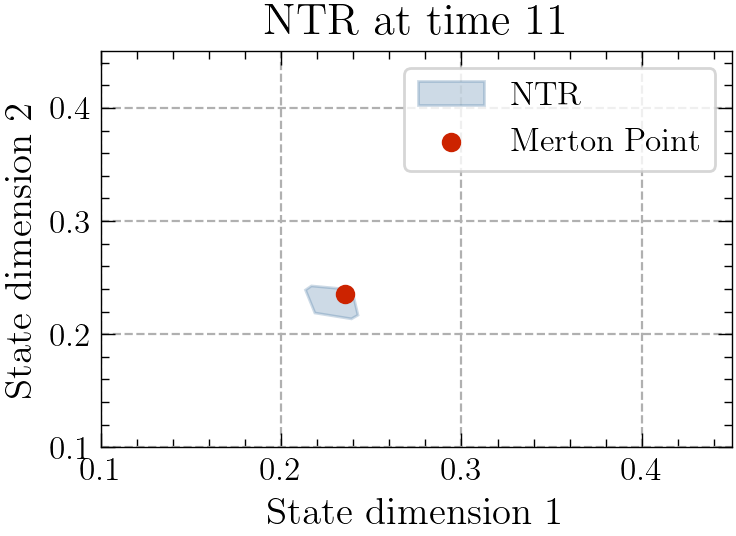

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_ntr_at_time(NTR_history, t):
    hull = NTR_history[t]
    
    if hull is not None:
        vertices = hull.points  # Vertices are stored in the 'points' attribute of ConvexHull
        D = vertices.shape[1]  # Dimension of the state space
        plt.figure(figsize=(4,3),dpi=200)

        if D == 2:
            # 2D plot
            # for simplex in hull.simplices:
            #     plt.plot(vertices[simplex, 0], vertices[simplex, 1], '-',color=colors[1])
            plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], color = colors[1], alpha=0.2,label='NTR')
            # plt.scatter(vertices[:, 0], vertices[:, 1], color='red')  # Plot the vertices
            plt.title(f'NTR at time {t}')
            plt.scatter(merton_p[0], merton_p[1],label='Merton Point')
            plt.legend()
            plt.xlabel('State dimension 1')
            plt.ylabel('State dimension 2')
            plt.xlim(0.1, 0.45)
            plt.ylim(0.1, 0.45)
        
        elif D == 3:
            # 3D plot
            ax = plt.axes(projection='3d')
            ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color='red')
            ax.add_collection3d(Poly3DCollection(vertices[hull.simplices], facecolors='lightgray', edgecolors='k', alpha=0.4))
            ax.scatter(merton_p[0], merton_p[1], merton_p[2], color='blue', s=100, label='Merton Point')
            ax.legend()
            ax.set_xlabel('State dimension 1')
            ax.set_ylabel('State dimension 2')
            ax.set_zlabel('State dimension 3')
            plt.title(f'NTR at time {t}')
            ax.set_xlim(0.15, 0.25)
            ax.set_ylim(0.15, 0.25)
            ax.set_zlim(0.15, 0.25)
        # Rotate the axes and update
        for angle in range(0, 360*4 + 1):
            # Normalize the angle to the range [-180, 180] for display
            angle_norm = (angle + 180) % 360 - 180

            # Cycle through a full rotation of elevation, then azimuth, roll, and all
            elev = azim = roll = 0
            if angle <= 360:
                elev = angle_norm
            elif angle <= 360*2:
                azim = angle_norm
            elif angle <= 360*3:
                roll = angle_norm
            else:
                elev = azim = roll = angle_norm

            # Update the axis view and title
            # ax.view_init(elev, azim, roll)        
        plt.show()

    else:
        print(f"Not enough vertices to form an NTR at time {t}")

# Example: Plot NTR at time t=1
plot_ntr_at_time(NTR,11)